# <span style="color:#ff8000">**Forest Fire Modelling**</span>

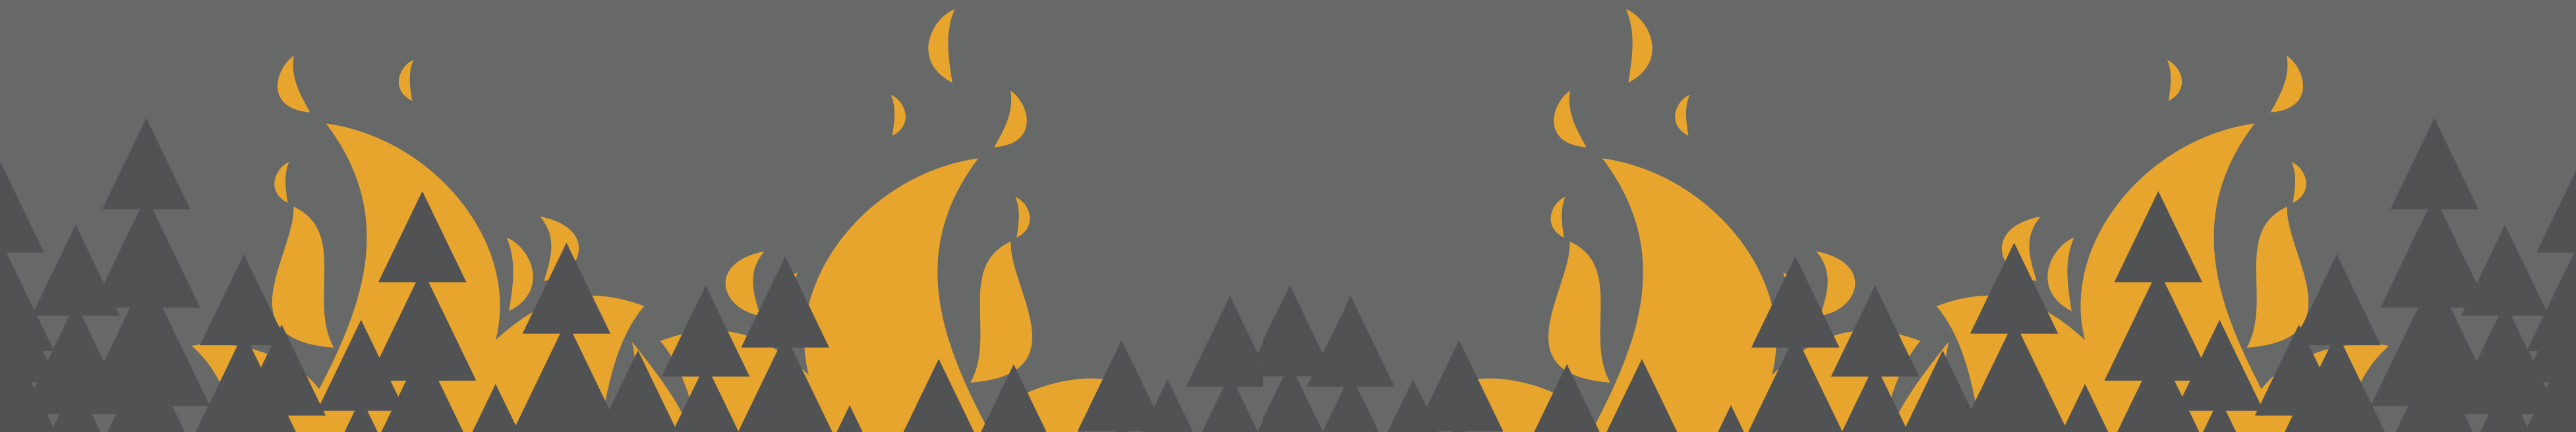

Forest fires can have natural and human-made causes. They spread via flame contact, radiation and convection-controlled ember transport. The spread - generally not very predictable - is dependent on topography, fuel and weather conditions. While forest fires can help maintain a healthy ecosystem, they can also have significant negative impacts on the environment and regional economy. Furthermore, they represent serious health risks to human and non-human animals. As a result of contemporary climate change and land-use change, the frequency of forest fires in North America, Australia and the Mediterranean region has increased. 

**In this exercise, you are introduced to a simple, idealised model that simulates the spread of forest fires by considering heat diffusion, fuel (wood) density changes, wind direction and other factors. You are then encouraged to modify the code to achieve specific tasks.**

## <span style="color:#ff8000">1. Underlying Mechanism</span>

Once a fire is ignited, it enters a quasi self-sustaining loop, as captured by the figure below. The cycle can only be broken by removing oxygen, heat or fuel. Since the fire burns (and therefore removes) fuel, it is slowly starving itself.

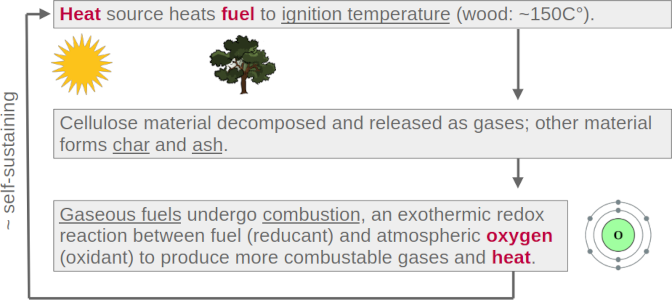

## <span style="color:#ff8000">2. Idealised Shape</span>

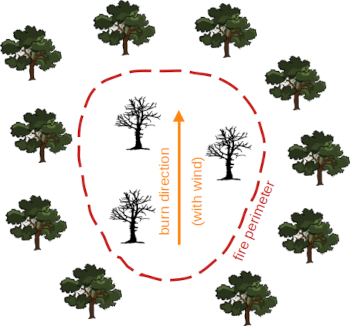

In an idealised setting, the forest fire will burn through the forest in the direction of the blowing wind (or uphill if on a slope). The burnt forest will be cone-shaped with the wider side of the cone facing in the direction of the forest fire. When plotting the output (forest density) of your wildfire model, you should see a cone-shaped pattern, too.

## <span style="color:#ff8000">3. Model Concept</span>

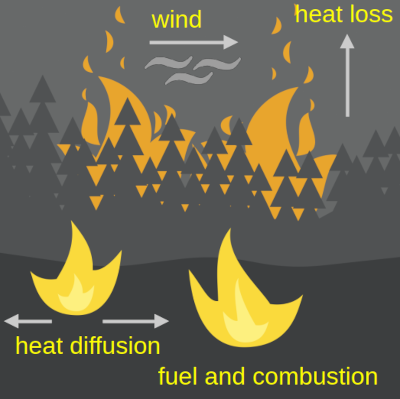

In our model of forest fire spread, we'll consider heat diffusion, heat loss to the environment, changes in fuel and combustion, and even aspects of weather (wind). Nevertheless, note that we simplify reality greatly by: 
- Ignoring a dimension! Ours is a 2D model.
- Assuming weather favours wildfires (it's warm and everything is dry).
- Assuming a flat topography. Slopes have important impacts on wildfire spread.
- Ignoring ember transport. Hot ember is often hurled through the air and ignites other areas.
- Ignoring fire – weather feedbacks. Fires create their own weather conditions.
- Assuming uniform fuel properties. We only use a single wood density value to represent an average that takes different types of wood and the spaces between trees into account.

Now let's have a close look at the important factors, variables and individual terms.

## <span style="color:#ff8000">4. Model Description</span>

### <span style="color:#a88c54">4.1. Important factors and variables</span>

- **$T_f$ - Forest Temperature** (unit=$K$): The temperature of your forest, which will be heated by your fire until it crosses the ignition temperature threshold and ignites.
- **$T_a$ - Ambient Temperature** (unit=$K$): This is the temperature of your surroundings, which is needed to consider heat loss of your forest.
- **$T_i$ - Ignition Temperature** (unit=$K$): This is the temperature threshold that needs to be crossed for your fuel (the wood in your forest) to ignite.
- **$F$ - Fuel Loading** (unit=$kg/m^{2}$): This represent the dry weight of the fuel per area. The fuel will be wood in this case. You can therefore think of it as wood density for this exercise.
- **$t_b$ - Burn Time** (unit=$s$): This is the time taken to burn specific amount of fuel (wood in your case).
- **$w$ - Wind Velocity** (unit=$m/s$): We will assume a uniform wind speed for the model domain. The wind will determine the direction of spread of your forest fire. Note that meridional (South-North) and zonal (West-East) wind components are treated seperately and typically referred to as **v** and **u** winds, respectively.

There are different ways of using these in a model that simulates the spread of a forest fire. Here, we use the Euler method (for solving ordinary differential equations). There are a few more variables we need to introduce for this type of model:

- **$x$ - Position along Forest** (unit=$m$): Unspectacular, but required!
- **$t$ - Time** (unit=$s$): Also quite self-explanatory.
- **$h$ - Constant** (unit=$s$): This is essentially a step size.

### <span style="color:#a88c54">4.2. Equation terms</span>

Here, we express the change in temperature of forest ($\delta T_f$) with respect to time due to heat diffusion ($\color{OliveGreen}\frac{\delta T_{fd}}{\delta t}$), heat loss ($\color{PineGreen}\frac{\delta T_{fl}}{\delta t} = \frac{T_a - T_f}{t}$) to the environment, and wind ($\color{SeaGreen}\frac{\delta T_{fw}}{\delta t}$), which we assume wind will simply shift the whole temperature distribution (and move the fire). 

$
\begin{align}
  \frac{\delta T_f}{\delta t}\ = \color{OliveGreen}\frac{\delta T_{fd}}{\delta t} \color{PineGreen} + \frac{\delta T_{fl}}{\delta t} + \color{SeaGreen} \frac{\delta T_{fw}}{\delta t} 
\end{align}
$

Notice that the above does not include any calculations of fuel change or temeprature change from burning yet? That's because burning is conditional on ignition. In our model, we will determine if the forest temperature is high enough to ignite it or not, and then calculate a) the change in fuel (wood) as it is burned, and b) the change in forest temperature.

At each cell, we can have one of 2 scenarios, which determines how we calculate the change in fuel and forest temperature:

$\color{blue}T_f < T_i$:
- $\Delta F = 0$
- $\Delta T_f = \frac{\delta T_f}{\delta t}$

$\color{red}T_f > T_i$: 
- $\Delta F = -h\frac{F}{t_b}$
- $\Delta T_f = h\frac{F}{t_b} + \frac{\delta T_f}{\delta t}$

In the blue scenario, the forest is below ignition temperature. We do not have any change in fuel (since we're not burning anything) and the forest temperature simply changes through heat loss (to the environment). In the red scenario, we ignite the forest. The fuel is changing at the burn rate $t_b$, and the forest temperature changes as a result of both heat diffusion and the heat produced by the burning.

## <span style="color:#ff8000">5. Model Code</span>

### <span style="color:#a88c54">5.1. Setup</span>

We start off by importing some simple Python packages we need for our calculations and plotting our results. Then, we set the boundary conditions by defining many of the above mentioned factors. As a last step in our setup section, we define some experiment specific parameters, such as the amount of time for which we let our fire spread and evolve.

In [31]:
# ==== Import Packages ==== #

import math
import numpy
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# ==== Declarations ==== #

# ---- boundary conditions for your model
rho_wood0  = 100. # starting wood density (kg / m^2); average taking empty spaces into account
u          = 0.05 # u-wind component (m / s)
v          = 0.2  # v-wind component (m / s)
T_a        = 303. # atmospheric/ambient terature (K); we assume a warm summer day (~30°C)

# ---- constants
T_ig       = 570.       # ignition terature (K); we assume dry wood (~300°C)
T_burn     = 1400.      # burn terature (K); typically between 1300-1400K for wood

r_diff     = 5.         # diffusion coefficient (m^2 / s)
C_loss     = 120.       # heat loss constant (s)
C_burnTime = 0.5*3600.  # 0.5h in seconds (s)
heating    = (T_burn-T_a)/(C_loss*100.)*C_burnTime # K / (kg / m^2)

# ---- define your geographical domain
length = 1000.          # domain length (m)
size   = 200            # number of grid points
dx     = length/size    # step size

# --- experiment 
h = 0.25*(dx**2/r_diff)  # time step size (s); 
end_time = 60.*5.        # simulation time (s); 5 minutes
pos_i = -40.,220         # how/where to start the fire

# --- other important variables used later in the code
# rho_wood1 - old wood density
# rho_wood2 - new wood density
# T_f1  - old forest Terature
# T_f2  - new forest Terature

### <span style="color:#a88c54">5.2. Starting the fire</span>

Let's now ready to examine how we start our fire. We create a function that creates a Gaussian temperature distribution according to pre-defined parameters.

In [27]:
# This is our function to start our forest fire.
def wildfire_start():
    
    # Set initial temperature to ambient temperature everywhere
    T_f1 = T_a*numpy.ones([size, size])  # K
    rho_wood1 = numpy.zeros([size, size]) # kg / m^2
    
    for j in range(0, size):
        for i in range(0, size):

            # convert grid points to real (physical) values
            x = i*dx-0.5*length+0.5*dx
            y = j*dx-0.5*length+0.5*dx
            
            # Starting the fire (don't do this in real life!): Here, an exponential function creates a 
            # Gaussian-shaped temperature field centred at pos_i, which decreases as you move away from the center. 
            # Adding T_a ensures that temperature far away from the centre is just the ambient temperature
            T_f1[j,i] = (T_burn-T_a)*math.exp(-((x+pos_i[0])**2+(y+pos_i[1])**2)/(2.*pos_i[0]**2))+T_a

            # Here, we initialise our wood density with the pre-defined value
            rho_wood1[j,i] = rho_wood0

    return T_f1, rho_wood1


### <span style="color:#a88c54">5.3. Letting the fire evolve</span>

Now, we get to the part of the model that actually simulated the evolution and spread of the wildfire, based on heat diffusion, heat loss, winds, and combustion.

In [28]:
# This is our function to simulate our wildfire. It returns updated forest
# temperatures and wood densities, which we later plot with wildfire_plot()
def wildfire_evolve(T_f1, rho_wood1):

    T_f2 = numpy.copy(T_f1)           # K
    rho_wood2 = numpy.copy(rho_wood1) # kg / m2
    num_steps = int(end_time/h)
    for step in range(num_steps):
        for j in range(1,size-1):
            for i in range(1,size-1):
                
                # Pass temeprature at current coordinates to T
                T = T_f1[j,i]
                
                # If below ignition temperature, set amount of burned wood and combustion to 0
                if T < T_ig:
                    wood_burn = 0
                    combustion = 0
                # If above ignition temperature, update amount of burned wood and combustion accordingly                    
                else:
                    # amount of wood burning per time
                    burn_rate = rho_wood1[j, i]/C_burnTime
                    # wood mass decreases as it burns (h = timestep)
                    wood_burn = -h*burn_rate
                    # The energy released by burning wood, contributing to temperature increase
                    combustion = h*heating*burn_rate

                # Below, we compute change in temperature and wood density due to heat diffusion, heat loss, wind, and combustion                    

                # This term models the spread of heat due to diffusion, following the discrete form of the heat equation.
                # The term inside parentheses sums up temperatures of neighboring grid points and subtracts 4T, 
                # ensuring conservation of heat energy. The coefficient r_diff/dx**2 controls the rate of diffusion.
                heat_diffusion = h*r_diff/dx**2*(T_f1[j,i-1]+T_f1[j,i+1]+T_f1[j-1,i]+T_f1[j+1,i]-4*T)

                # Here, we compute the cooling based on heat loss to the surroundings.
                # The constant C_loss controls the rate at which heat is lost.
                heat_loss = h*(T_a-T)/C_loss

                # Here, we calculate heat advection due to wind in the x- and y-directions. The wind 
                # velocity components u and v move the temperature field along their respective directions.
                wind_x = -h*u/dx*0.5*(T_f1[j,i+1]-T_f1[j,i-1])
                wind_y = -h*v/dx*0.5*(T_f1[j+1,i]-T_f1[j-1,i])

                # Update wood density based on what was burned.
                rho_wood2[j,i] = rho_wood1[j,i]+wood_burn

                # Update the forest temperature based on a combination of all the temperature modifying
                # factors calculated above.
                T_f2[j,i] = T+combustion+heat_diffusion+heat_loss+wind_x+wind_y

        # Pass updated forest temperature and wood density        
        T_f1,T_f2 = T_f2,T_f1
        rho_wood1,rho_wood2 = rho_wood2,rho_wood1
        
    return T_f1, rho_wood1


### <span style="color:#a88c54">5.4. Visualisation</span>

Finally, we need a function that lets us visualise our results.

In [29]:
# This function plots our modelled results: A map of temperature and a map of wood density
def wildfire_plot():
    # Set dimensions
    dimensions = [-0.5*length, 0.5*length, -0.5*length, 0.5*length]

    # temperature plot
    axes = plt.subplot(221)
    plt.imshow(T_f1, cmap=cm.hot, origin='lower', vmin=200, vmax=1300)
    plt.colorbar()
    axes.set_title('temperature ($K$)')
    axes.set_xlabel('x (m)')
    axes.set_ylabel('y (m)')

    # wood density plot
    axes = plt.subplot(222)
    plt.imshow(rho_wood1, cmap=cm.summer_r, origin='lower', vmin=50, vmax=100)
    plt.colorbar()
    axes.set_title('wood density ($kg/m^2$)')
    axes.set_xlabel('x (m)')
    axes.set_ylabel('y (m)')
    plt.show()


### <span style="color:#a88c54">5.5. Running the model</span>

We're all set! Now it's time to use our functions!

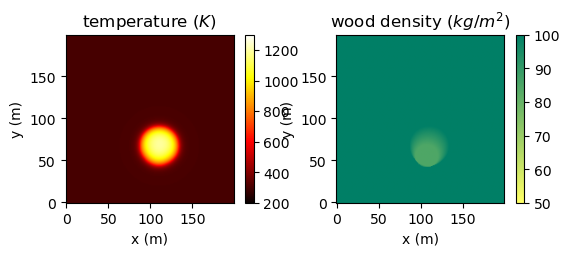

In [32]:
# Here, we start the fire. The function returns an updated forest temperaturee and wood density.
T_f1, rho_wood1 = wildfire_start()    

# Here, we activate the function that lets our fire evolve. We pass the updated values to the function,
# run the model for the previously defined time, and finally get back the values for temperature and
# wood density that represents a snapshot of these values at the end of our simulation.
T_f1, rho_wood1 = wildfire_evolve(T_f1, rho_wood1)

# Here, we call the plot function to visualise our results.
wildfire_plot()


## <span style="color:#ff8000">6. Your Tasks</span>

We have a working model. Yay! However, the results do not look particularly interesting yet. Let's make it more exciting!

### <span style="color:#a88c54">6.1. Experiment with Parameters (without AI help)</span>

- **Simulation Time**: It looks like the fire hasn't spread very much yet. That's not surprising, since we only let it burn for 5 minutes. Extend the time a little to see how the fire continues to evolve.
- **Wood Density**: What do you think happens if the wood density is lower? Think about it and make a prediction. Then, change the starting wood density, run the code again and see if you were right.
- **Winds**: We had some weak winds blowing NNE. How about we change the direction, double the v (S-N) component (set it to 0.4) and watch what happens?

### <span style="color:#a88c54">6.2. Non-Uniform Forests (with AI help)</span>

Our forest looks quite boring so far. It's perfectly uniform. Why not make it more exciting as we initialise wood density and set fire to it in the *wildfire_start()* function. For example:
- Why not **introduce a treeline** in the middle of the geographical domain, so we have dense wood in the south and a lower density (perhaps shrublands?) in the north?
- Alternatively, you could **introduce some noise** to the uniform density field to represent variations in tree density in your forest?
- **Perhaps you can think of something even more creative to burn down? Go wild!** (It's safe if done in a simulation!)

## <span style="color:#ff8000">Appendix</span>

### <span style="color:#a88c54">Reading</span>

Qingkai Kong, Timmy Siauw, Alexandre M. Bayen: Chapter 22 - Ordinary Differential Equations (ODEs) Initial-Value Problems, Editor(s): Qingkai Kong, Timmy Siauw, Alexandre M. Bayen,
Python Programming and Numerical Methods, Academic Press, 2021, Pages 371-398, ISBN 9780128195499, https://doi.org/10.1016/B978-0-12-819549-9.00032-4. **You can access the chapter [here](https://pythonnumericalmethods.studentorg.berkeley.edu/notebooks/chapter22.03-The-Euler-Method.html).**

### <span style="color:#a88c54">Acknowledgements</span>

Thanks to **Sarah Falkowski**, **Lucy Heaney**, **Emily Thomson**, and **Anya Gray** for their useful feedback. 